# Постановка задачи
 Нам необходимо будет работать с датасетом, в котором содержатся сведения о 515 000 отзывов на отели Европы. Модель, которую  будет обучать, должна предсказывать рейтинг отеля по данным сайта Booking на основе имеющихся в датасете данных.

## Предоставлены данные от компании Booking. Данные содержат следующие столбцы:
* *hotel_address* — адрес отеля;
* review_date* — дата, когда рецензент разместил соответствующий отзыв;
* average_score* — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
* hotel_name* — название отеля;
* reviewer_nationality* — страна рецензента;
* *negative_review* — отрицательный отзыв, который рецензент дал отелю;
* *review_total_negative_word_counts* — общее количество слов в отрицательном отзыв;
* *positive_review* — положительный отзыв, который рецензент дал отелю;
* *review_total_positive_word_counts* — общее количество слов в положительном отзыве.
* *reviewer_score* — оценка, которую рецензент поставил отелю на основе своего опыта;
* *total_number_of_reviews_reviewer_has_given* — количество отзывов, которые рецензенты дали в прошлом;
* *total_number_of_reviews* — общее количество действительных отзывов об отеле;
* *tags* — теги, которые рецензент дал отелю;
* *days_since_review* — количество дней между датой проверки и датой очистки;
* *additional_number_of_scoring* — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* *lat* — географическая широта отеля;
* *lng* — географическая долгота отеля.

## 1. Загрузка и обработка данных 

In [448]:
# Загружаем интрументы, которые нам понадобятся для эффективной работы.
from geopy.geocoders import Yandex

import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms
from statsmodels.stats.descriptivestats import sign_test

import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from sklearn import preprocessing
import category_encoders as ce

In [449]:
# Используем Api ключ для дальнейшей работы с геоданными.
geolocator = Yandex(api_key='8a1cae4d-9573-40d3-8329-c856fc981cba')

#### Файл был скачен по [ссылке](https://drive.google.com/file/d/1Qj0iYEbD64eVAaaBylJeIi3qvMzxf2C_/view)

In [450]:
# скачиваем датасет
data = pd.read_csv('hotels.csv')
data.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


### 1.1 Проверка на наличие пропусков и работа с ними.

In [451]:
# Проверяем на наличие пропусков в столбцах

def nul_func(x):
    lst_null=[]
    for i in x.columns:
        if int(x[i].count()) < int(x.shape[0]):
            
            lst_null.append(i)
    return lst_null
print(f'Пропуски в столбцах: {nul_func(data)}') 
print('----------------------------------------')
data.info()

Пропуски в столбцах: ['lat', 'lng']
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64 

In [452]:
# Получаем список уникальных адресов ателей, которые имеют пропущенные данные в признаках 'lat' и 'lng'
a=data[data['lat'].isna()].groupby('hotel_address',as_index=False).count()
list(a['hotel_address'])

['20 Rue De La Ga t 14th arr 75014 Paris France',
 '23 Rue Damr mont 18th arr 75018 Paris France',
 '4 rue de la P pini re 8th arr 75008 Paris France',
 'Bail n 4 6 Eixample 08010 Barcelona Spain',
 'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria',
 'Hasenauerstra e 12 19 D bling 1190 Vienna Austria',
 'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria',
 'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria',
 'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria',
 'Paragonstra e 1 11 Simmering 1110 Vienna Austria',
 'Pau Clar s 122 Eixample 08009 Barcelona Spain',
 'Savoyenstra e 2 16 Ottakring 1160 Vienna Austria',
 'Sep lveda 180 Eixample 08011 Barcelona Spain',
 'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria',
 'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria',
 'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria',
 'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria']

In [453]:
dict_hotel_address={}
for i in list(a['hotel_address']):
    location = geolocator.geocode(i)
    dict_hotel_address[i]=[float(location[1][0]),float(location[1][1])]
dict_hotel_address    
    

{'20 Rue De La Ga t 14th arr 75014 Paris France': [48.838331, 2.330948],
 '23 Rue Damr mont 18th arr 75018 Paris France': [48.856663, 2.351556],
 '4 rue de la P pini re 8th arr 75008 Paris France': [48.856663, 2.351556],
 'Bail n 4 6 Eixample 08010 Barcelona Spain': [41.396133, 1.655829],
 'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria': [48.222139, 16.357513],
 'Hasenauerstra e 12 19 D bling 1190 Vienna Austria': [48.778035, 15.65565],
 'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria': [48.210918,
  16.347119],
 'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria': [48.210918,
  16.347119],
 'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria': [48.206487,
  16.36346],
 'Paragonstra e 1 11 Simmering 1110 Vienna Austria': [48.176599, 16.413999],
 'Pau Clar s 122 Eixample 08009 Barcelona Spain': [41.504994, 2.245959],
 'Savoyenstra e 2 16 Ottakring 1160 Vienna Austria': [48.211783, 16.297308],
 'Sep lveda 180 Eixample 08011 Barcelona Spain': [41.425226, 2.18

In [454]:
# Заполняем недостающие значения теми, которые у нас есть.
for value in  dict_hotel_address:   
    data.loc[data['hotel_address']==value,'lat']=dict_hotel_address[value][0]
    data.loc[data['hotel_address']==value,'lng']=dict_hotel_address[value][1]
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

* Итак, у нас нет пропущенных данных в датасете.

### 1.2 Классификация всех признаков на числовые и категориальные.

In [455]:
unique_list = []
# пробегаемся по именам столбцов в таблице
for col in data.columns:
    # создаём кортеж (имя столбца, число уникальных значений)
    item = (col, data[col].nunique(),data[col].dtypes)     # добавляем кортеж в список
    unique_list.append(item) 
# создаём вспомогательную таблицу и сортируем её
unique_counts = pd.DataFrame(
    unique_list,
    columns=['Column_Name', 'Num_Unique', 'Type']
).sort_values(by='Num_Unique',  ignore_index=True)
# выводим её на экран
display(unique_counts)

,Column_Name,Num_Unique,Type
0,average_score,34,float64
1,reviewer_score,37,float64
2,total_number_of_reviews_reviewer_has_given,194,int64
3,reviewer_nationality,225,object
4,review_total_positive_word_counts,354,int64
5,review_total_negative_word_counts,402,int64
6,additional_number_of_scoring,480,int64
7,review_date,731,object
8,days_since_review,731,object
9,total_number_of_reviews,1142,int64


* Признаки представлены следующим образом:
  Девять признаков являются числовыми.
  Восемь признаков являются категориальными на первый взгляд.

## 2. Разведывательный анализ данных

### 2.1 Визуализация признаков.

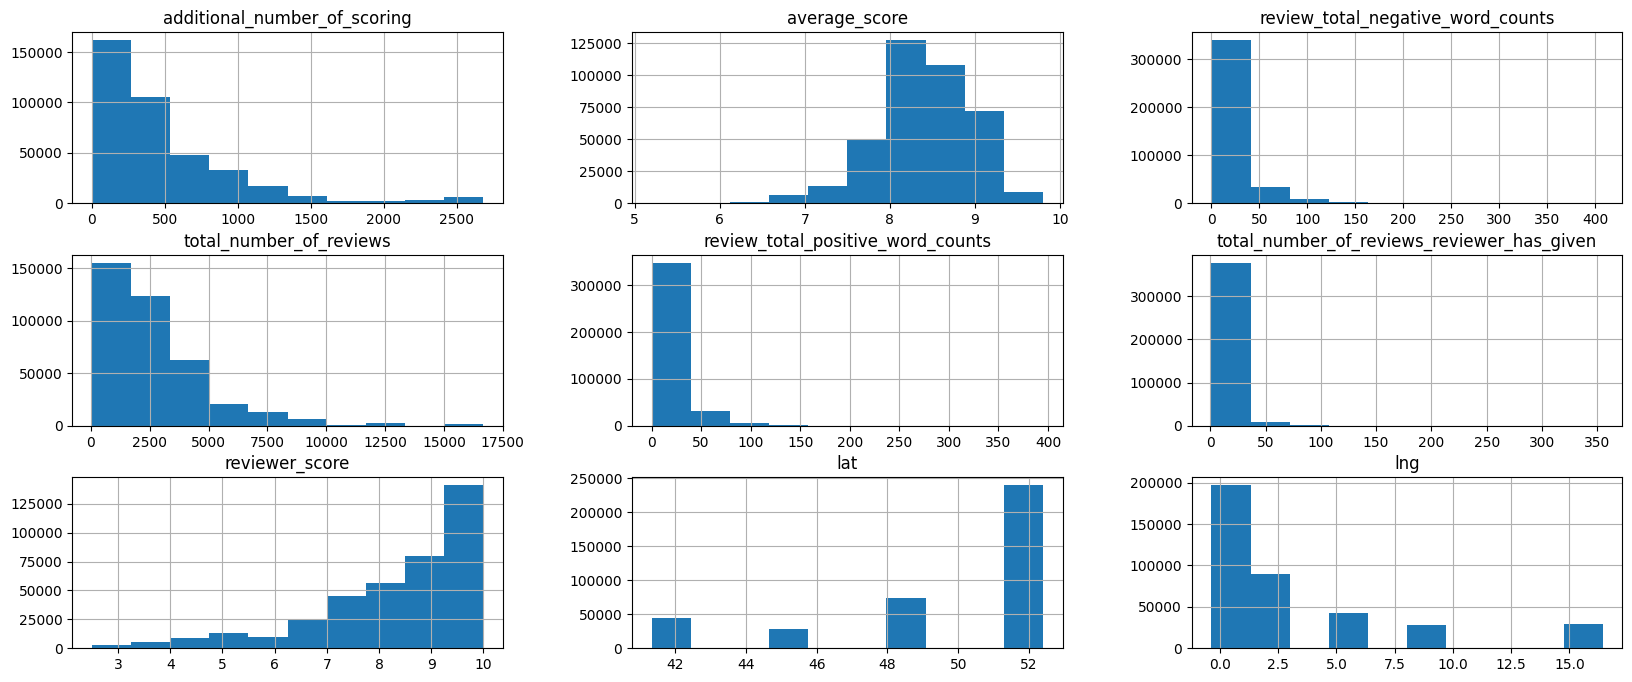

In [456]:
# Числовые признаки.
data.hist(figsize=(20,8));

Данные распределены не нормально.

In [457]:
# рассмотрим основные статистические данные нашего датасета.
data.describe(include='all')

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
count,386803,386803.000000,386803,386803.000000,386803,386803,386803,386803.000000,386803.000000,386803,386803.000000,386803.00000,386803.000000,386803,386803,386803.000000,386803.000000
unique,1493,NaN,731,NaN,1492,225,248828,NaN,NaN,311737,NaN,NaN,NaN,47135,731,NaN,NaN
top,163 Marsh Wall Docklands Tower Hamlets London ...,NaN,8/2/2017,NaN,Britannia International Hotel Canary Wharf,United Kingdom,No Negative,NaN,NaN,No Positive,NaN,NaN,NaN,"[' Leisure trip ', ' Couple ', ' Double Room '...",1 days,NaN,NaN
freq,3587,NaN,1911,NaN,3587,184033,95907,NaN,NaN,26885,NaN,NaN,NaN,3853,1911,NaN,NaN
mean,NaN,498.246536,NaN,8.397231,NaN,NaN,NaN,18.538988,2743.992042,NaN,17.776985,7.17725,8.396906,NaN,NaN,49.433518,2.892178
std,NaN,500.258012,NaN,0.547881,NaN,NaN,NaN,29.703369,2316.457018,NaN,21.726141,11.05442,1.636090,NaN,NaN,3.460906,4.665969
min,NaN,1.000000,NaN,5.200000,NaN,NaN,NaN,0.000000,43.000000,NaN,0.000000,1.00000,2.500000,NaN,NaN,41.328376,-0.369758
25%,NaN,169.000000,NaN,8.100000,NaN,NaN,NaN,2.000000,1161.000000,NaN,5.000000,1.00000,7.500000,NaN,NaN,48.214277,-0.143372
50%,NaN,342.000000,NaN,8.400000,NaN,NaN,NaN,9.000000,2134.000000,NaN,11.000000,3.00000,8.800000,NaN,NaN,51.499981,0.019886
75%,NaN,660.000000,NaN,8.800000,NaN,NaN,NaN,23.000000,3613.000000,NaN,22.000000,8.00000,9.600000,NaN,NaN,51.516288,4.841163


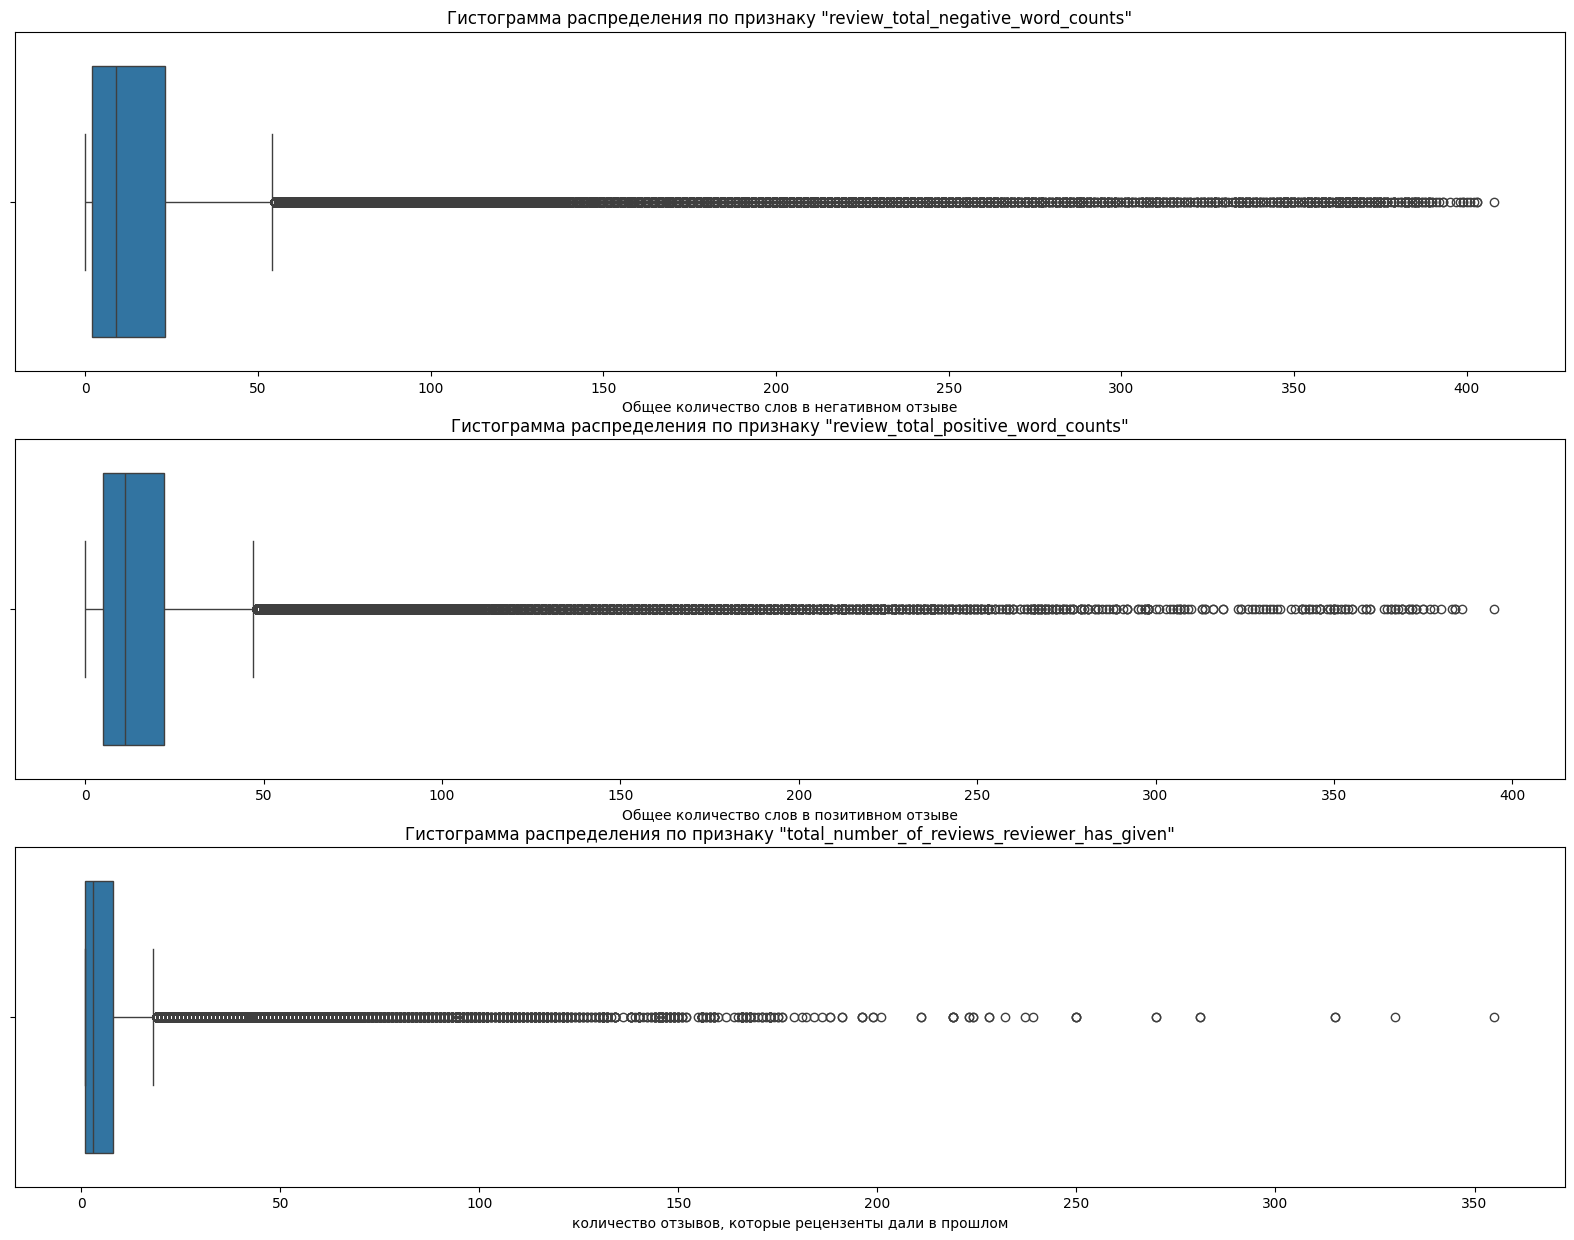

In [458]:
# Построим оси координат для трех графиков.
fig,(ax)=plt.subplots(3,1,figsize=(20,15))
sns.boxplot(data,x='review_total_negative_word_counts',ax=ax[0]);
# Общее количество слов в отрицательных отзывов
ax[0].set(xlabel='Общее количество слов в негативном отзыве');
ax[0].set_title('Гистограмма распределения по признаку "review_total_negative_word_counts"');
# Общее количество слов в положительных отзывов
sns.boxplot(data,x='review_total_positive_word_counts',ax=ax[1]);
ax[1].set(xlabel='Общее количество слов в позитивном отзыве');
ax[1].set_title('Гистограмма распределения по признаку "review_total_positive_word_counts"');
# количество отзывов, которые рецензенты дали в прошлом
sns.boxplot(data,x='total_number_of_reviews_reviewer_has_given',ax=ax[2]);
ax[2].set(xlabel='количество отзывов, которые рецензенты дали в прошлом');
ax[2].set_title('Гистограмма распределения по признаку "total_number_of_reviews_reviewer_has_given"');

На данных графиках видно, что распределение не нормальное. Так же можно сказать, что у признаков очень много выбросов, т.к. данные признаки представляют собой отзывы посетителей отелей и содержат от 200 до 400 уникальных значений.
- review_total_positive_word_counts
- review_total_negative_word_counts
- total_number_of_reviews_reviewer_has_given


Но у нас есть два признака, которые по распределению похожи на категориальный, а точнее на порядковый признак, когда мы рассматриваем год какого либо действия. Поэтому признаки 'lat' и 'lng' следует рассмотреть поближе.

Визуализация категориальных признаков рассмотрим после их преобразования.

## 3 Работа над новыми признаками. Преобразование признаков.

### 3.1 Признаки lat и lng.


In [459]:
print(f"- Количество уникальных значений в признаке lng:{data['lng'].nunique()}.")
print()
print(f"- Количество уникальных значений в признаке lat:{data['lat'].nunique()}.")

- Количество уникальных значений в признаке lng:1485.

- Количество уникальных значений в признаке lat:1485.


Количество уникальных значений в данных признаках по 1485. Что очень много для дальнейшей работы с ним. Преобразуем их, округлив до целого. Так же в lng есть отрицательные значения, с которыми в дальнейшем мы не сможем работать. Так же их преобразуем в положительные.

In [460]:
# Так же изменим тим данных столбца, чтобы убрать знаки после  запятой.
data['lng']=data['lng'].round().apply(lambda x: -x if x==0 else x).astype('int')
data['lat']=data['lat'].round().astype('int')
print(f"- Количество уникальных значений в признаке lng:{data['lng'].nunique()}.")
print()
print(f"- Количество уникальных значений в признаке lat:{data['lat'].nunique()}.")

- Количество уникальных значений в признаке lng:5.

- Количество уникальных значений в признаке lat:8.


В итоге у нас осталось в каждом признаке уникальных значений до 10. в lng - 5, в lat-8.

### 3.2 Признаки negative_review и positive_review

In [461]:
print(f"- Количество уникальных значений в признаке lng:{data['negative_review'].nunique()}.")
print()
print(f"- Количество уникальных значений в признаке lat:{data['positive_review'].nunique()}.")

- Количество уникальных значений в признаке lng:248828.

- Количество уникальных значений в признаке lat:311737.


Колосальное количество уникальных значений в признаках. Т.к. данные представлены в виде текста, найдем среди строк самые популярные слова, исключив все слова в которых не менее 4х букв. Так как тут надо учитывать особенности английского словаря.

In [462]:
# Создаем пустой словарь для заполнения его всеми словами, которые будут встречаться в столбце negative_review   
dct_negative={}
# Запускаем цикл для всех строк, переделанных в список
for i in data['negative_review'].str.split(' '):
# Внутри еще один цикл для всех элементов списка в каждой строке, мы будем слова добавлять в наш созданный ранее словарь и подсчитывать их количества, внося в значение.    
    for j in i:
        j=j.strip()
        if j in dct_negative:
            dct_negative[j]+=1
        else:
            dct_negative[j]=1
# 
lst_negative_review=sorted(dct_negative.items(), key=lambda item: item[1],reverse=True)
# Создаем список, куда мы будем вносить уже слова, без значений.
lst_negative_review_new=[]
# Запускаем цикл для всех пар ключ-значение в списке lst_negative_review и уже в список lst_tags_new мы добавляем только слова.
for i in lst_negative_review:
    lst_negative_review_new.append(i[0])
print(list(filter(lambda x: len(x)>4,lst_negative_review_new))[:20])


['Negative', 'hotel', 'small', 'breakfast', 'staff', 'there', 'could', 'would', 'rooms', 'Nothing', 'which', 'night', 'bathroom', 'little', 'shower', 'service', 'Breakfast', 'really', 'expensive', 'reception']


У нас получился список всех слов, которые встречаются в столбце negative_review', отсортированные по количеству вхождений в столбце. Из них мы выберем 5 самых популярных слов, которые могут влиять на отзыв. 

In [463]:
word_1='Negative' # Негатив, слово, которое встречается чаще всего.
word_2='Small' # Тут подразумеваются словосочитания, маленькая комната. В общем слово, которое характеризует размер номера.
word_3='breakfast' # Завтрак.
word_4='Staff' # персонал.
word_5='Bathroom' # Ванная. Т.к. тут тоже оно часто встречается в негативных отзывах.

In [464]:
# Создаем новые признаки, куда мы заносим уже информацию в виде числовых значений, 1-это значит True, 0-False.
# И у нас в итоге получается 5 новых признаков. 
# И сразу рассмотрим соотношение строк где есть данное слово к строкам, где его нет.
print() 
data['negative_review_Negative'] = data['negative_review'].str.contains(word_1,case=False).astype('int')
print(data['negative_review_Negative'].value_counts())
print()
data['negative_review_Small'] = data['negative_review'].str.contains(word_2,case=False).astype('int')
print(data['negative_review_Small'].value_counts())
print()
data['negative_review_Breakfast'] = data['negative_review'].str.contains(word_3,case=False).astype('int')
print(data['negative_review_Breakfast'].value_counts())
print()
data['negative_review_Staff'] = data['negative_review'].str.contains(word_4,case=False).astype('int')
print(data['negative_review_Staff'].value_counts())
print()
data['negative_review_Bathroom'] = data['negative_review'].str.contains(word_5,case=False).astype('int')
print(data['negative_review_Bathroom'].value_counts())

#  И удаляем наш признак negative_review', т.к. он нам больше не понадобится.
data.drop(['negative_review'],axis=1,inplace=True)


0    289451
1     97352
Name: negative_review_Negative, dtype: int64

0    350486
1     36317
Name: negative_review_Small, dtype: int64

0    349442
1     37361
Name: negative_review_Breakfast, dtype: int64

0    360604
1     26199
Name: negative_review_Staff, dtype: int64

0    367460
1     19343
Name: negative_review_Bathroom, dtype: int64


In [465]:
data[['negative_review_Negative','negative_review_Small','negative_review_Breakfast','negative_review_Staff','negative_review_Bathroom']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 5 columns):
 #   Column                     Non-Null Count   Dtype
---  ------                     --------------   -----
 0   negative_review_Negative   386803 non-null  int64
 1   negative_review_Small      386803 non-null  int64
 2   negative_review_Breakfast  386803 non-null  int64
 3   negative_review_Staff      386803 non-null  int64
 4   negative_review_Bathroom   386803 non-null  int64
dtypes: int64(5)
memory usage: 14.8 MB


У нас получились новые признаки, которые для нас более информативнее чем признак с таким большим количеством уникальных значений.

Дальше такое же действие проделываем и для признака positive_review'

In [466]:
# Создаем пустой словарь для заполнения его всеми словами, которые будут встречаться в столбце positive_review  
dct_positive={}
# Запускаем цикл для всех строк, переделанных в список
for i in data['positive_review'].str.split(' '):
# Внутри еще один цикл для всех элементов списка в каждой строке, мы будем слова добавлять в наш созданный ранее словарь и подсчитывать их кол-во, внося в значение.    
    for j in i:
        j=j.strip()
        if j in dct_positive:
            dct_positive[j]+=1
        else:
            dct_positive[j]=1
# Сортируем словарь по значениям и в порядке убывания. На выходе получаем список кортежей(ключ-значение)
lst_positive_review=sorted(dct_positive.items(), key=lambda item: item[1],reverse=True)
lst_positive_review_new=[]
# Запускаем цикл для всех пар ключ-значение в списке lst_negative_review и уже в список lst_tags_new мы добавляем только слова.
for i in lst_positive_review:
    lst_positive_review_new.append(i[0])
print(list(filter(lambda x: len(x)>4,lst_positive_review_new))[:20])

['staff', 'location', 'hotel', 'helpful', 'friendly', 'great', 'breakfast', 'clean', 'Location', 'comfortable', 'excellent', 'Great', 'Staff', 'Positive', 'rooms', 'station', 'lovely', 'close', 'really', 'service']


Выбираем 5 слов, одни из самых популярных и подходящих нам. В рамках данного признака.

In [467]:
word_6='Staff'# Персонал. Тут он встречается чаще.
word_7='location' # Местоположение отеля.
word_8='breakfast' #Завтрак.
word_9='helpful' # Полезный.
word_10='friendly'# Дружелюбный.

In [468]:
# Создаем новые признаки, куда мы заносим уже информацию в виде числовых значений, 1-это значит True, 0-False.
# И у нас в итоге получается 5 новых признаков. 
# И сразу рассмотрим соотношение строк где есть данное слово к строкам, где его нет.
print()
data['positive_review_Staff'] = data['positive_review'].str.contains(word_6,case=False).astype('int')
print(data['positive_review_Staff'].value_counts())
print()
data['positive_review_Location'] = data['positive_review'].str.contains(word_7,case=False).astype('int')
print(data['positive_review_Location'].value_counts())
print()
data['positive_review_Breakfast'] = data['positive_review'].str.contains(word_8,case=False).astype('int')
print(data['positive_review_Breakfast'].value_counts())
print()
data['positive_review_Helpful'] = data['positive_review'].str.contains(word_9,case=False).astype('int')
print(data['positive_review_Helpful'].value_counts())
print()
data['positive_review_Friendly'] = data['positive_review'].str.contains(word_10,case=False).astype('int')
print(data['positive_review_Friendly'].value_counts())
# И удаляем признак positive_review, т.к. он нам больше не пригодится.
data.drop(['positive_review'],axis=1,inplace=True)


0    244724
1    142079
Name: positive_review_Staff, dtype: int64

0    244759
1    142044
Name: positive_review_Location, dtype: int64

0    324933
1     61870
Name: positive_review_Breakfast, dtype: int64

0    328015
1     58788
Name: positive_review_Helpful, dtype: int64

0    323428
1     63375
Name: positive_review_Friendly, dtype: int64


У нас так же получилось 5 новых признаков, которые мы сделали из того, где было очень большое количество уникальных значений.

In [469]:
data[['positive_review_Staff','positive_review_Location','positive_review_Breakfast','positive_review_Helpful','positive_review_Friendly']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 5 columns):
 #   Column                     Non-Null Count   Dtype
---  ------                     --------------   -----
 0   positive_review_Staff      386803 non-null  int64
 1   positive_review_Location   386803 non-null  int64
 2   positive_review_Breakfast  386803 non-null  int64
 3   positive_review_Helpful    386803 non-null  int64
 4   positive_review_Friendly   386803 non-null  int64
dtypes: int64(5)
memory usage: 14.8 MB


### 3.3 Признак days_since_review

Данный признак по количеству уникальных значений полностью похож на признак review_date. И по смыслу является его следствием, т.к. признак показывает, сколько дней прошло с момента написания отзыва, а признак review_date показывает дату написания отзыва. Мы его оставим и преобразуем в числовой неприрывный признак, что бы посмотреть на тепловой карте его зависимость с другими признаками.

In [470]:
data['days_since_review']=data['days_since_review'].str.replace('days','')
data['days_since_review']=data['days_since_review'].str.replace('day','').astype('int')

### 3.4 Признак hotel_name

Рассмотрим топ 10 самых популярных значений в данном признаке.

In [471]:
data['hotel_name'].value_counts().head(10)

Britannia International Hotel Canary Wharf           3587
Strand Palace Hotel                                  3206
Park Plaza Westminster Bridge London                 3095
Copthorne Tara Hotel London Kensington               2688
DoubleTree by Hilton Hotel London Tower of London    2379
Grand Royale London Hyde Park                        2218
Holiday Inn London Kensington                        2097
Hilton London Metropole                              1982
Intercontinental London The O2                       1939
Millennium Gloucester Hotel London                   1889
Name: hotel_name, dtype: int64

По данным выше нет ярко выраженных популярных значений. Поэтому решил взять всего 5. Остальные отметить как Other

In [472]:
# берем список с 5 самыми популярными названиями отелей.
lst_hotel_name=list(data['hotel_name'].value_counts().head(5).index)
# Преобразуем столбце hotel_name
data['hotel_name']=data['hotel_name'].apply(lambda x: x if x in lst_hotel_name else 'Other')
# кодируем данные из столбца hotel_name методом однократного кодирования.
encoder = ce.OneHotEncoder(cols=['hotel_name'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data['hotel_name'])
data= pd.concat([data, type_bin], axis=1)
# Удаляем столбец hotel_name, т.к. он нам больше не пригодится.
data.drop(['hotel_name'],axis=1,inplace=True)

Получили очередные 6 новых столбцов из признака, в данном случае: hotel_name

In [473]:
data[['hotel_name_Britannia International Hotel Canary Wharf','hotel_name_Strand Palace Hotel',
      'hotel_name_Park Plaza Westminster Bridge London','hotel_name_Copthorne Tara Hotel London Kensington',
      'hotel_name_DoubleTree by Hilton Hotel London Tower of London','hotel_name_Other']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 6 columns):
 #   Column                                                        Non-Null Count   Dtype
---  ------                                                        --------------   -----
 0   hotel_name_Britannia International Hotel Canary Wharf         386803 non-null  int64
 1   hotel_name_Strand Palace Hotel                                386803 non-null  int64
 2   hotel_name_Park Plaza Westminster Bridge London               386803 non-null  int64
 3   hotel_name_Copthorne Tara Hotel London Kensington             386803 non-null  int64
 4   hotel_name_DoubleTree by Hilton Hotel London Tower of London  386803 non-null  int64
 5   hotel_name_Other                                              386803 non-null  int64
dtypes: int64(6)
memory usage: 17.7 MB


### 3.5 Признак review_date

Данный признак представляет собой дату. Узнаем когда были написаны самый ранний отзыв и самый поздний. 

In [474]:
display(pd.to_datetime(data['review_date']).sort_values())

143997   2015-08-04
86268    2015-08-04
159209   2015-08-04
217001   2015-08-04
28485    2015-08-04
            ...    
167325   2017-08-03
372341   2017-08-03
54669    2017-08-03
321881   2017-08-03
315137   2017-08-03
Name: review_date, Length: 386803, dtype: datetime64[ns]

In [475]:
# Узнаем количество уникальных значений в данном признаке.
print(f"Количество уникальных значений в признаке review_date: {pd.to_datetime(data['review_date']).nunique()}")

Количество уникальных значений в признаке review_date: 731


Очень большое количество уникальных значений. Мы можем их преобразовать, взяв год и месяц.

In [476]:
data['review_year']=pd.to_datetime(data['review_date']).dt.year
data['review_month']=pd.to_datetime(data['review_date']).dt.month

Посмотрим, сколько стало и после удалим признак review_date.

In [477]:
# Узнаем количество уникальных значений в новых признаках.
print(f"Количество уникальных значений в признаке review_date: {data['review_year'].nunique()}")
print()
print(f"Количество уникальных значений в признаке review_date: {data['review_month'].nunique()}")


Количество уникальных значений в признаке review_date: 3

Количество уникальных значений в признаке review_date: 12


Отлично, с этим будем работать дальше. Удаляем признак review_date

In [478]:
data.drop(['review_date'],axis=1,inplace=True)

### 3.6 Признак reviewer_nationality

Данный признак является номинальным возьмем топ 15 значений и проанализируем их.

In [479]:
data['reviewer_nationality'].value_counts().head(15)

 United Kingdom               184033
 United States of America      26541
 Australia                     16239
 Ireland                       11126
 United Arab Emirates           7617
 Saudi Arabia                   6722
 Netherlands                    6608
 Switzerland                    6498
 Canada                         5984
 Germany                        5956
 France                         5543
 Israel                         4918
 Italy                          4562
 Belgium                        4529
 Turkey                         4105
Name: reviewer_nationality, dtype: int64

Далее рассмотрим, сколько они занимают процентов от общего количества строк.

In [480]:
display(round(data['reviewer_nationality'].value_counts().head(15).sum()/data['reviewer_nationality'].value_counts().sum()*100,2))

77.81

Оставляем только эти значения в столбце reviewer_nationality, а остальные значения заполняем строкой Other

In [481]:
lst_nationality=list(data['reviewer_nationality'].value_counts().head(15).index)
data['reviewer_nationality']=data['reviewer_nationality'].apply(lambda x:x if x in lst_nationality else ' Other ')
display(data['reviewer_nationality'].value_counts())

 United Kingdom               184033
 Other                         85822
 United States of America      26541
 Australia                     16239
 Ireland                       11126
 United Arab Emirates           7617
 Saudi Arabia                   6722
 Netherlands                    6608
 Switzerland                    6498
 Canada                         5984
 Germany                        5956
 France                         5543
 Israel                         4918
 Italy                          4562
 Belgium                        4529
 Turkey                         4105
Name: reviewer_nationality, dtype: int64

И кодируем сразу однократным кодированием,после удаляем столбец reviewer_nationality

In [482]:
encoder = ce.OneHotEncoder(cols=['reviewer_nationality'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data['reviewer_nationality'])
data= pd.concat([data, type_bin], axis=1)
data.drop(['reviewer_nationality'],axis=1,inplace=True)

### 3.7 Признак hotel_address

Уточним количество уникальных значений в данном столбце.

In [483]:
data['hotel_address'].nunique()

1493

Для дальнейшей работы количество большое. Выделим из признака только страну. И удалим признак hotel_address

In [484]:
data['hotel_country']=data['hotel_address'].apply(lambda x:' ' .join(x.split(' ')[-2:]) if x.split(' ')[-2]=='United' else  x.split(' ')[-1])
data['hotel_country'].value_counts()
data.drop(['hotel_address'],axis=1,inplace=True)

In [485]:
data['hotel_country'].value_counts()

United Kingdom    196774
Spain              45132
France             44830
Netherlands        43006
Austria            29178
Italy              27883
Name: hotel_country, dtype: int64

У нас получился новый признак с 6 уникальными значениями. Сразу закодируем данные однократным кодированием. И удалим признак hotel_country

In [486]:
encoder = ce.OneHotEncoder(cols=['hotel_country'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data['hotel_country'])
data = pd.concat([data, type_bin], axis=1)
data.drop(['hotel_country'],axis=1,inplace=True)

### 3.8 Признак tags

В данном признаке мы можем взять информацию о том, какое количество ночей самое популярное при бронировании номера. Так же количество уникальных значений тегов и самые популярные словосочетания. 

In [487]:
# Выясняем, какое количество ночей чаще всего предпочитают посетители отелей.
# Создадим функцию, которая будет находить количество ночей бронирования.
def func_1(x):
    x=x.split(',')
    for i in x:
        if ' Stayed' in i:
            for j in i:
                if j.isdigit():
                    return int(j)
        else:
            continue
    return 0
# В новый признак уже заносим информацию о количестве ночей бронирования.         
data['tags_night']=data['tags'].apply(func_1)
display(data['tags_night'].value_counts())

1    147116
2    100348
3     72010
4     35748
5     15611
6      7399
7      5549
8      1910
9       966
0       146
Name: tags_night, dtype: int64

Чаще всего бронируют на одну ночь.

Теперь выясним, какой самый популярный тег.

In [488]:
# Создаем пустой словарь. 
dct_tag={}
# Запускаем цикл, который проходит по всем элементам столбца и сумирует все слова друг с другом, после заносит информацию в созданный нами ранее словарь.
for i in data['tags']:
    i=i.replace('[','')
    i=i.replace(']','')
    i=i.replace("'","")
    i=i.split(' ,  ') 
    for j in i:
        j=j.strip()
        if j in dct_tag:
            dct_tag[j]+=1
        else:
            dct_tag[j]=1
print(sorted(dct_tag.items(), key=lambda item: item[1],reverse=True)[0])  
# Выяснили, что самый популярный tag 'Leisure trip'

('Leisure trip', 313593)


Выясняем количество уникальных тегов.

In [489]:
# Количество уникальных значений в признаке tags
print(f"Количество уникальных значений в признаке tags: {len(dct_tag)}")

Количество уникальных значений в признаке tags: 2368


Нам необходимо из данного признака получить дополнительную информацию, которую мы бы использовали дальше. Найдем самые популярные теги. Топ10

In [490]:

lst_tags=sorted(dct_tag.items(), key=lambda item: item[1],reverse=True)[:14]
lst_tags_new=[]
for i in lst_tags:
    if 'Stayed' in i[0]:
        continue
    else:
        lst_tags_new.append(i[0])
lst_tags_new

['Leisure trip',
 'Submitted from a mobile device',
 'Couple',
 'Solo traveler',
 'Business trip',
 'Group',
 'Family with young children',
 'Double Room',
 'Standard Double Room',
 'Superior Double Room']

Создадим уже в нашем датасете новые признаки, добавив к названию приставку tags_, чтобы не путались.

In [491]:
# запишем в переменные все те теги, которые мы будем искать.
word_11='Leisure trip'
word_12='Submitted from a mobile device'
word_13='Solo traveler'
word_14='Business trip'
word_15='Group'
word_16='Family with young children'
word_17='Double Room'
word_18='Standard Double Room'
word_19='Superior Double Room'
word_20='Couple'

In [492]:
# Создаем новые признаки, куда мы заносим уже информацию в виде числовых значений, 1-это значит True, 0-False.
data['tags_Leisure trip'] = data['tags'].str.contains(word_11,case=False).astype('int')
data['tags_Submitted from a mobile device'] = data['tags'].str.contains(word_12,case=False).astype('int')
data['tags_Solo traveler'] = data['tags'].str.contains(word_13,case=False).astype('int')
data['tags_Business trip'] = data['tags'].str.contains(word_14,case=False).astype('int')
data['tags_Group'] = data['tags'].str.contains(word_15,case=False).astype('int')
data['tags_Family with young children'] = data['tags'].str.contains(word_16,case=False).astype('int')
data['tags_Double Room'] = data['tags'].str.contains(word_17,case=False).astype('int')
data['tags_Standard Double Room'] = data['tags'].str.contains(word_18,case=False).astype('int')
data['tags_Superior Double Room'] = data['tags'].str.contains(word_19,case=False).astype('int')
data['tags_Family with older children'] = data['tags'].str.contains(word_20,case=False).astype('int')

Теперь занесем информацию в наши столбцы по тегам

In [493]:

display(data['tags_Leisure trip'].value_counts())
display(data['tags_Submitted from a mobile device'].value_counts())
display(data['tags_Solo traveler'].value_counts())
display(data['tags_Business trip'].value_counts())
display(data['tags_Group'].value_counts())
display(data['tags_Family with young children'].value_counts())
display(data['tags_Double Room'].value_counts())
display(data['tags_Standard Double Room'].value_counts())
display(data['tags_Superior Double Room'].value_counts())
display(data['tags_Family with older children'].value_counts())

1    313593
0     73210
Name: tags_Leisure trip, dtype: int64

1    230778
0    156025
Name: tags_Submitted from a mobile device, dtype: int64

0    305568
1     81235
Name: tags_Solo traveler, dtype: int64

0    324814
1     61989
Name: tags_Business trip, dtype: int64

0    337715
1     49088
Name: tags_Group, dtype: int64

0    340967
1     45836
Name: tags_Family with young children, dtype: int64

0    236854
1    149949
Name: tags_Double Room, dtype: int64

0    359548
1     27255
Name: tags_Standard Double Room, dtype: int64

0    360081
1     26722
Name: tags_Superior Double Room, dtype: int64

0    197591
1    189212
Name: tags_Family with older children, dtype: int64

Удаляем признак tags, т.к. нам он уже не нужен.

In [494]:
data.drop(['tags'],axis=1,inplace=True)

In [495]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 61 columns):
 #   Column                                                        Non-Null Count   Dtype  
---  ------                                                        --------------   -----  
 0   additional_number_of_scoring                                  386803 non-null  int64  
 1   average_score                                                 386803 non-null  float64
 2   review_total_negative_word_counts                             386803 non-null  int64  
 3   total_number_of_reviews                                       386803 non-null  int64  
 4   review_total_positive_word_counts                             386803 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given                    386803 non-null  int64  
 6   reviewer_score                                                386803 non-null  float64
 7   days_since_review                                       

У нас получилось 61 признак в сумме. И все представлены в числовом формате.

## 4 Проверка на мультиколлинеарность. Отбор признаков.

### 4.1 Тепловая карта

Построим для всех наших признаков тепловую карту.

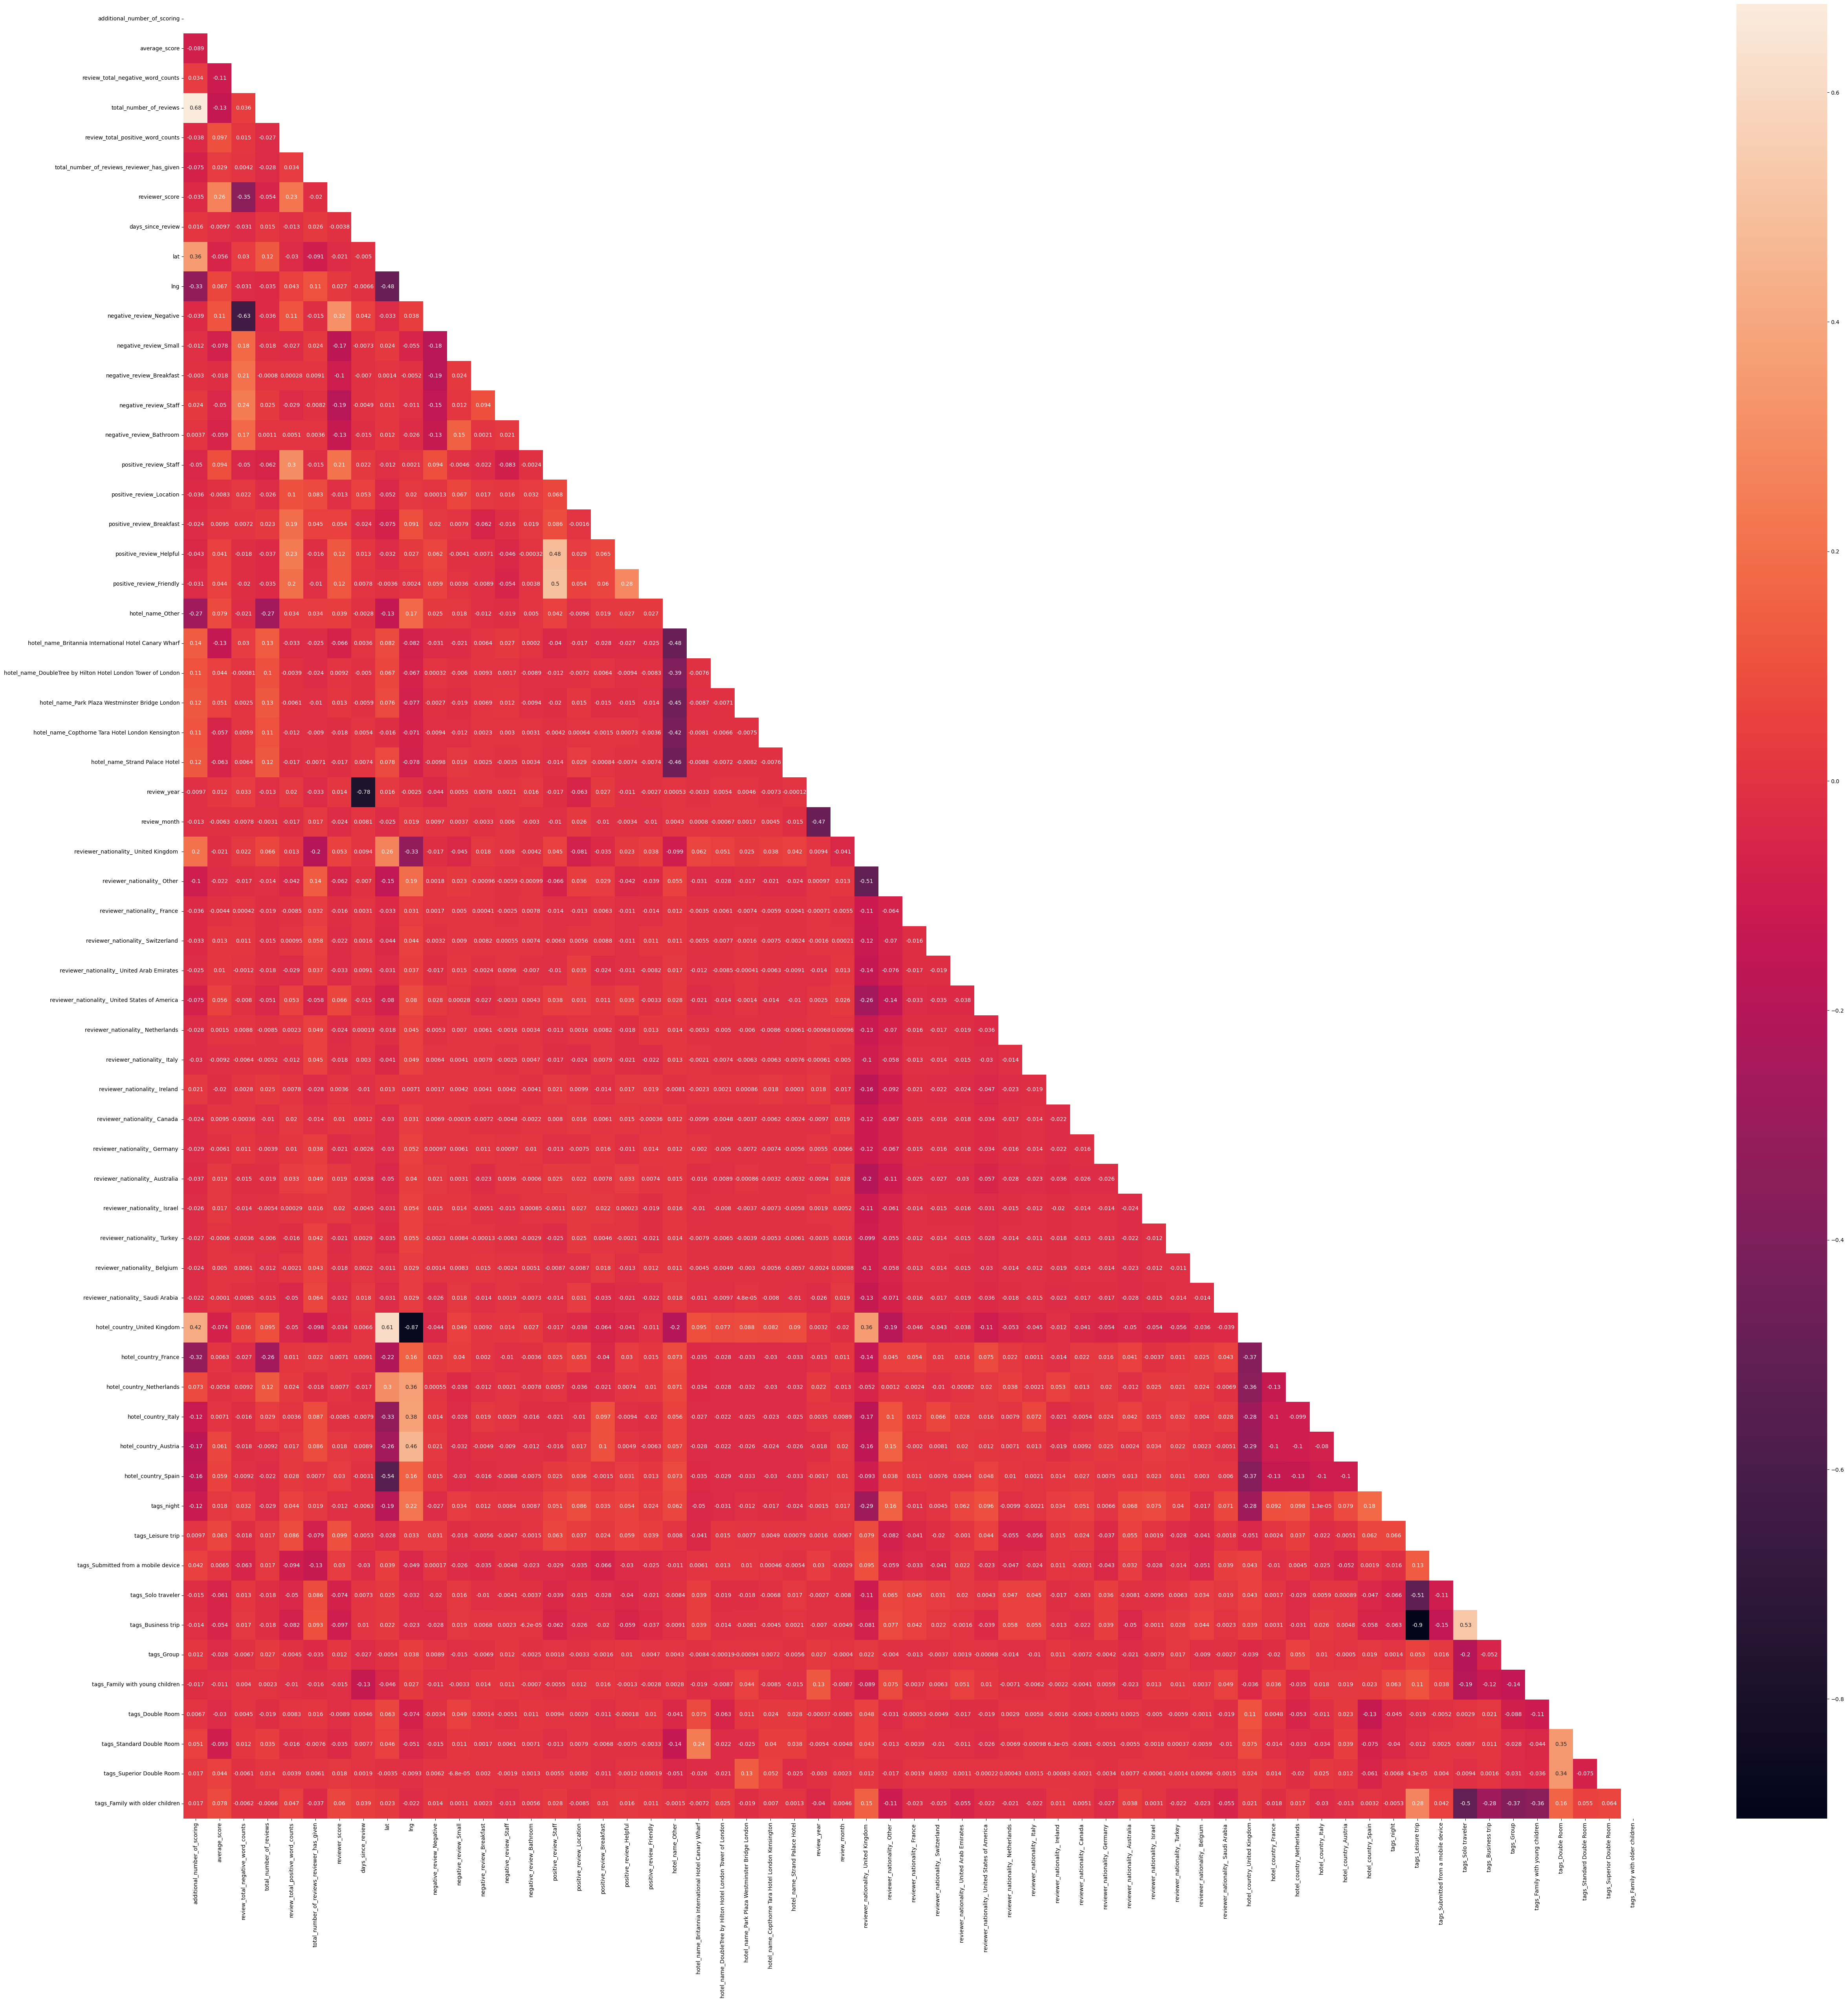

In [496]:
fig,(a)=plt.subplots(1,1,figsize=(60,60))
matrix=np.triu(data.corr(method='kendall'))
sns.heatmap(data.corr(method='kendall'), annot=True, mask=matrix);

После анализа данного графика удаляем столбцы, у которых показатели корреляции выше 0.7

In [497]:
data=data.drop(['hotel_country_United Kingdom','tags_Business trip','days_since_review'],axis=1)

## 5. Оценка значимости признаков.

Разбиваем датафрейм на части, необходимые для обучения и тестирования модели.  Х — данные с информацией об отелях, у — целевая переменная (рейтинги отелей)

In [498]:
X = data.drop(['reviewer_score'], axis = 1)  
y = data['reviewer_score']  
      
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  
      
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" — для тестирования.  
# Для тестирования мы будем использовать 25 % от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### 5.1 Оценка значимости

Разделим все признаки в перпеменной X на числовые и категориальные.

In [499]:
#Для оценки значимости категориальных признаков будем использовать тест хи-квадрат, для непрерывных признаков — тест ANOVA.
# непрерывные признаки
num_cols = ['review_total_negative_word_counts',
            'review_total_positive_word_counts','total_number_of_reviews_reviewer_has_given',
            'additional_number_of_scoring','total_number_of_reviews']
# Категориальные признаки.
cat_cols = []
# Напишем цикл, который добавит в список все названия колонок, кроме непрерывных признаков.
for col in X.columns:
    if col not in num_cols:
        cat_cols.append(col)


Для оценки значимости категориальных признаков будем использовать тест хи-квадрат

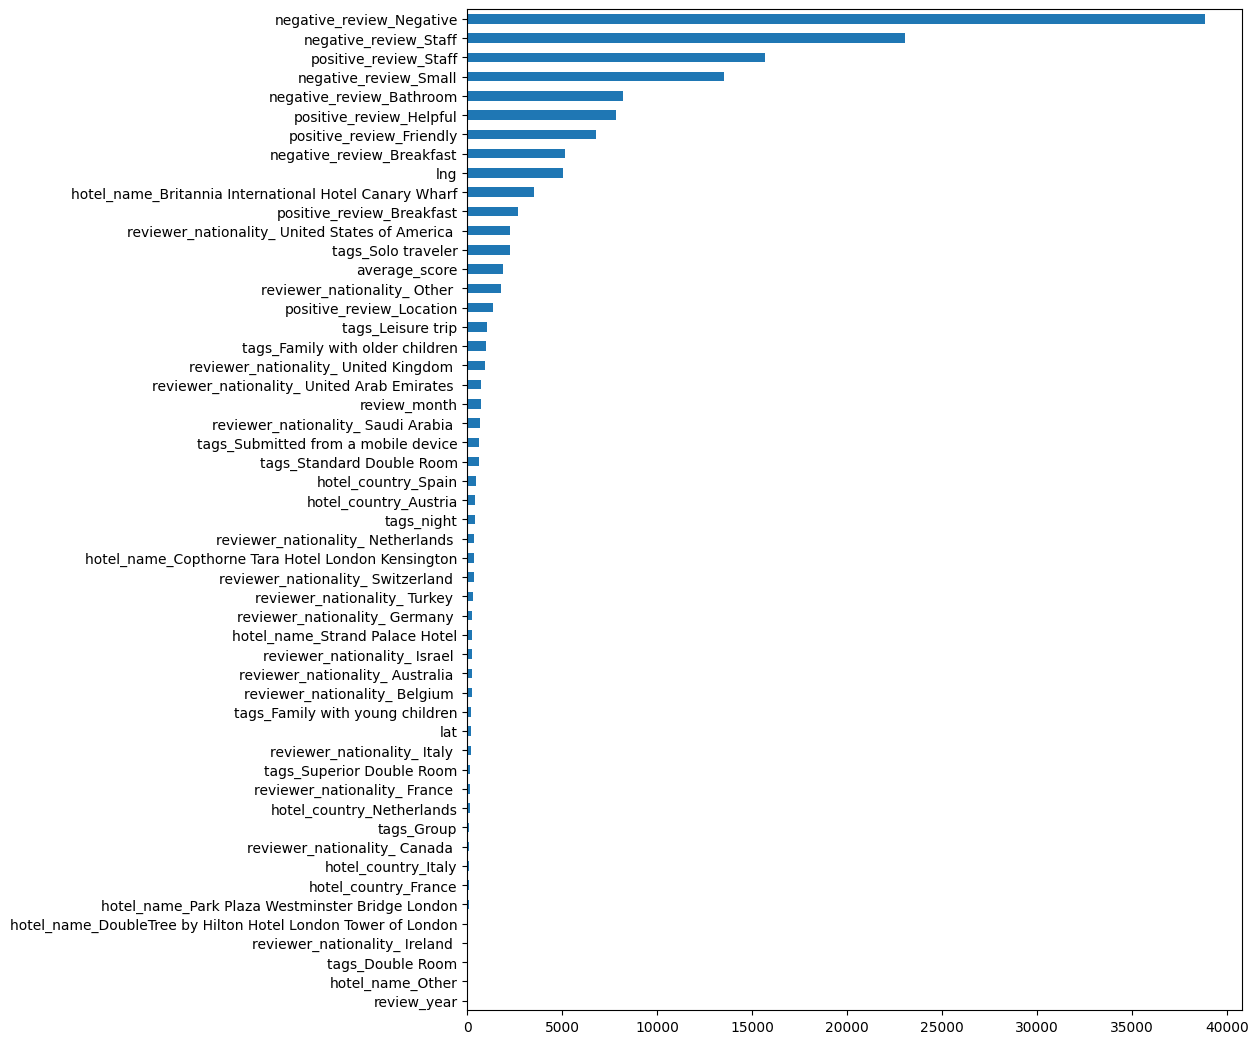

In [500]:
y=y.astype('int')

from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh',figsize=(10,13));

Для оценки значимости непрерывных признаков — тест ANOVA.

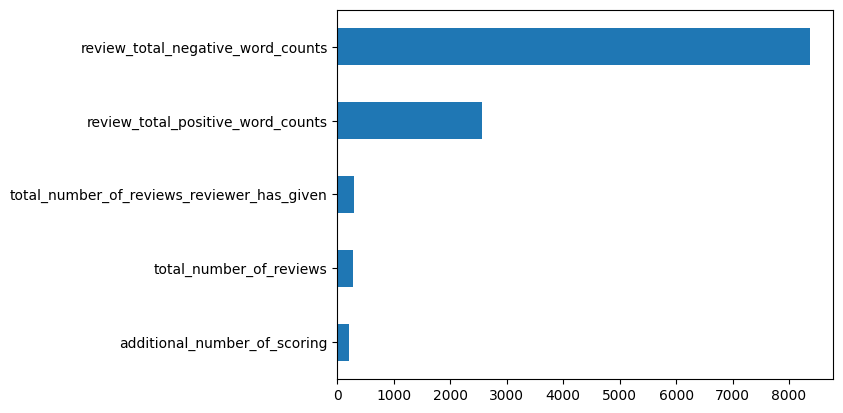

In [501]:
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh');

### 5.2 Преобразование признаков. Нормализация.

In [502]:
col_names=list(X.columns)
r_scaler = preprocessing.RobustScaler()
# кодируем исходный датасет
df_r = r_scaler.fit_transform(X)
# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
X = pd.DataFrame(df_r, columns=col_names)

## 6. Машинное обучение.

In [503]:
 # Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
    
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
    
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
    
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.13200486536246084
